In [ ]:
input_model = "roberta"

In [ ]:
BASE_PATH = 'drive/MyDrive/MIDS/w266/02_final_project/mids-w266-project/'

In [ ]:
#@title Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Install the required packages required for the notebook and execution of XML-Roberta
pydot: This package is used for generating and visualizing graphs. It is commonly used in conjunction with tools like Graphviz.

gensim: A robust library for topic modeling and document similarity, particularly useful for tasks such as word embeddings, topic modeling, and document similarity.

tensorflow==2.15.0: This specifies the installation of version 2.15.0 of TensorFlow, a popular deep learning framework developed by Google.

tf_keras==2.15.0: This installs TensorFlow's implementation of Keras, ensuring compatibility with the specified version of TensorFlow.

tensorflow-datasets==4.8: This installs version 4.8 of tensorflow-datasets, a collection of ready-to-use datasets for use with TensorFlow.

tensorflow-text==2.15.0: This installs version 2.15.0 of tensorflow-text, a library that extends TensorFlow with text processing capabilities.

transformers==4.17: This installs version 4.17 of the transformers library by Hugging Face, which provides pre-trained models and tools for NLP tasks.

pyyaml: A YAML parser and emitter for Python, often used for configuration files.

h5py: A package for reading and writing HDF5 files, a popular format for storing large amounts of numerical data.

In [ ]:
#@title Installs
!pip install pydot --quiet
!pip install gensim --quiet
!pip install tensorflow==2.15.0 --quiet #15 13
!pip install tf_keras==2.15.0 --quiet
!pip install tensorflow-datasets==4.8 --quiet #8
!pip install tensorflow-text==2.15.0 --quiet #15
!pip install transformers==4.17 --quiet #4.40.2 #4.37.2
!pip install pyyaml h5py

In [ ]:
#@title Imports

import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
import tensorflow_datasets as tfds
import tensorflow_text as tf_text
import transformers

from tensorflow.keras.optimizers import Adam
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification

from transformers import BertTokenizer, TFBertModel, BertConfig, TFBertForSequenceClassification
from transformers import RobertaTokenizer, TFRobertaModel, RobertaConfig, TFRobertaForSequenceClassification
from transformers import DistilBertTokenizer, TFDistilBertModel, DistilBertConfig, TFDistilBertForSequenceClassification
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, AutoConfig

from transformers import logging
logging.set_verbosity_error()

import matplotlib.pyplot as plt
import seaborn as sns


import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score


import re

import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import datapath

In [ ]:
#@title Global tunable parameters

# Sequence length to truncate/pad
MAX_SEQUENCE_LENGTH = 128 #256 #512

# hidden layer size after BERT's ouput
HIDDEN_LAYER_SIZE = 128 #256 #512

# Max embeddings in BERT
ROBERTA_MAX_EMBEDDINGS = 128 #256 #512

# fraction of data to use for training
# FRACTION = 1.0

# Base path to store trained snapshot and results
BASE_PATH = 'drive/MyDrive/MIDS/w266/02_final_project/mids-w266-project/'

In [ ]:
#@title Utility print function

def print_version(library_name):
    try:
        lib = __import__(library_name)
        version = getattr(lib, '__version__', 'Version number not found')
        print(f"{library_name} version: {version}")
    except ImportError:
        print(f"{library_name} not installed.")
    except Exception as e:
        print(f"An error occurred: {e}")

#confirm versions
print_version('numpy')
print_version('transformers')
print_version('tensorflow')
print_version('keras')
print_version('pandas')
print_version('sklearn')

numpy version: 1.26.4
transformers version: 4.17.0
tensorflow version: 2.15.0
keras version: 2.15.0
pandas version: 2.1.4
sklearn version: 1.3.2


In [ ]:
#@title Utility Plot Function

# 4-window plot. Small modification from matplotlib examples.

def make_plot(axs,
              model_history1,
              model_history2,
              model_1_name='model 1',
              model_2_name='model 2',
              ):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    for i, metric in enumerate(['loss', 'accuracy']):
        # small adjustment to account for the 2 accuracy measures in the Weighted Averging Model with Attention
        if 'classification_%s' % metric in model_history2.history:
            metric2 = 'classification_%s' % metric
        else:
            metric2 = metric

        y_lim_lower1 = np.min(model_history1.history[metric])
        y_lim_lower2 = np.min(model_history2.history[metric2])
        y_lim_lower = min(y_lim_lower1, y_lim_lower2) * 0.9

        y_lim_upper1 = np.max(model_history1.history[metric])
        y_lim_upper2 = np.max(model_history2.history[metric2])
        y_lim_upper = max(y_lim_upper1, y_lim_upper2) * 1.1

        for j, model_history in enumerate([model_history1, model_history2]):
            model_name = [model_1_name, model_2_name][j]
            model_metric = [metric, metric2][j]
            ax1 = axs[i, j]
            ax1.plot(model_history.history[model_metric])
            ax1.plot(model_history.history['val_%s' % model_metric])
            ax1.set_title('%s - %s' % (metric, model_name))
            ax1.set_ylabel(metric, bbox=box)
            ax1.set_ylim(y_lim_lower, y_lim_upper)

In [ ]:
rdt_trainfile = f'{BASE_PATH}/Reddit/titles_train.csv'
rdt_tesstfile = f'{BASE_PATH}/Reddit/titles_test.csv'
rdt_valfile = f'{BASE_PATH}/Reddit/titles_val.csv'

rdt_train = pd.read_csv(rdt_trainfile)
rdt_test = pd.read_csv(rdt_tesstfile)
rdt_val = pd.read_csv(rdt_valfile)

In [ ]:
rdt_train

,ID,title,class_name,class_id
0,691324c4-5c30-44e0-b9e4-45b4f0715e21,a question about the third conditional.,none,5
1,d4295391-9ca5-4398-b7c8-687e4a984ef1,the epitome of my life,adhd,0
2,58937fa5-3c2c-426b-8255-5a140fbab675,what are your favourites offbeat destinations ...,none,5
3,7daf364c-3b33-4cbe-be37-a214edf9a73e,synesthesia survey (what colour is each month ...,none,5
4,22518271-4bb4-4caf-b683-7305da519288,"science ama series: i’m phil baran, and i’m he...",none,5
...,...,...,...,...
13722,386a4117-0324-4b25-8330-b1a6857ccaa6,trying to wake up and leave the house every mo...,bipolar,2
13723,4dd92d63-1231-410d-b049-5d8c430c2f36,"""hey man, what'd you do this past weekend?""",depression,3
13724,dbde1d3e-e527-4cf8-8045-2093aec2a784,"how to use "" whereby "" correctly?",none,5
13725,5355fad6-5bb4-4092-8428-9b8527a6d261,"i'm sorry, another depression post",bipolar,2


In [ ]:
rdt_test

,ID,title,class_name,class_id
0,b07b978c-7760-4932-85cb-5797b5e74168,"basic needs for neurotypicals : food, clothing...",adhd,0
1,b2868fd2-e885-400e-b780-446c9581b1f1,"""you're just an iphone in an android world.: d...",adhd,0
2,3191b3b1-d355-41b6-9588-caeb3e169c9b,"""what kind of music do you listen to?"" no answer",adhd,0
3,a3d60895-ef7c-4b57-b5be-632c9fd62150,couldn’t help crying while reading a post that...,adhd,0
4,66fae18e-e744-495f-b7a0-b985543f5052,shout-out to all the parents with adhd childre...,adhd,0
...,...,...,...,...
1483,5855d35b-bf7d-4a49-8030-b185f430f05a,i went on a solo motorcycle ride from tamil na...,none,5
1484,a2faea38-8b93-43da-a75b-cb7c0ba1ae0d,hello and namaste to r/india... from r/nepal. ...,none,5
1485,7ad72b7f-eba4-4c17-90b0-1038dc144a8b,public api for the largest video game database...,none,5
1486,e73c198f-5e8e-4c84-aedf-333b576f9939,acs ama: hi reddit! my name is dr. john m news...,none,5


In [ ]:
rdt_val

,ID,title,class_name,class_id
0,34db02f0-82ed-43e9-ac8b-65db8ba55a95,do others feel like they have a warped sense o...,adhd,0
1,f515fc3a-0f62-4203-bfc8-53a8252a8fc1,do you ever feel like one small failure can de...,adhd,0
2,93ed44ff-20b8-4bc2-b71b-6c7a39fa4775,so you've heard about getting a song in your h...,adhd,0
3,e9ec2f5b-f709-40c4-b4f2-202ebbe5bc87,anyone here have listening comprehension probl...,adhd,0
4,2e6f28e3-acbe-44ac-82f0-a980aa07a464,i finally found a way to wake my ass up in the...,adhd,0
...,...,...,...,...
1483,55acf4ff-e555-4804-8a15-b3e9a27aecbc,psa: wear earplugs to concerts.,none,5
1484,b4821450-78a9-4fde-8da0-9e99a39a49db,as a cop that worked the may day protests (and...,none,5
1485,d0cea880-458c-41ad-a464-82183fca0bd5,how to increase your listening skills?,none,5
1486,7346a22c-4f59-459c-815b-f3c79e67a8fa,i'm in treatment for drugs and alcohol and wou...,none,5


In [ ]:
#@title Read Reddit dataset into a dataframe
# rdt_trainfile = f'{BASE_PATH}/Reddit/both_train.csv'
# rdt_tesstfile = f'{BASE_PATH}/Reddit/both_test.csv'
# rdt_valfile = f'{BASE_PATH}/Reddit/both_val.csv'

# rdt_train = pd.read_csv(rdt_trainfile)
# rdt_test = pd.read_csv(rdt_tesstfile)
# rdt_val = pd.read_csv(rdt_valfile)

# Shuffle all rows
rdt_train = rdt_train.sample(frac=1).reset_index(drop=True)
rdt_val = rdt_val.sample(frac=1).reset_index(drop=True)
rdt_test = rdt_test.sample(frac=1).reset_index(drop=True)


# Split data into test and train
# train_size = int(0.8 * len(rdt_train))
X_train = rdt_train.title
X_val = rdt_val.title
X_test = rdt_test.title
y_train = rdt_train.class_id
y_val = rdt_val.class_id
y_test = rdt_test.class_id

train_labels = np.array(y_train)
test_labels = np.array(y_test)
val_labels = np.array(y_val)

train_examples_list = []
test_examples_list = []
val_examples_list = []

temp_train_examples = np.array(X_train)
temp_test_examples = np.array(X_test)
temp_val_examples = np.array(X_val)

for i in range(len(temp_train_examples)):
  size = len(temp_train_examples[i])
  lower = int(0.3*MAX_SEQUENCE_LENGTH)
  upper = int(0.7*MAX_SEQUENCE_LENGTH)
  if size > MAX_SEQUENCE_LENGTH:
    train_examples_list.append(temp_train_examples[i][:lower] + temp_train_examples[i][upper:])
  else:
    train_examples_list.append(temp_train_examples[i])

for i in range(len(temp_test_examples)):
  size = len(temp_test_examples[i])
  lower = int(0.3*size)
  upper = int(0.7*size)
  if size > MAX_SEQUENCE_LENGTH:
    test_examples_list.append(temp_test_examples[i][:lower] + temp_test_examples[i][upper:])
  else:
    test_examples_list.append(temp_test_examples[i])

for i in range(len(temp_val_examples)):
  size = len(temp_val_examples[i])
  lower = int(0.3*size)
  upper = int(0.7*size)
  if size > MAX_SEQUENCE_LENGTH:
    val_examples_list.append(temp_val_examples[i][:lower] + temp_val_examples[i][upper:])
  else:
    val_examples_list.append(temp_val_examples[i])

train_examples = np.array(train_examples_list)
test_examples = np.array(test_examples_list)
val_examples = np.array(val_examples_list)


In [ ]:
print(rdt_train.class_name.unique())
rdt_train.class_id.unique()

['adhd' 'anxiety' 'bipolar' 'depression' 'none' 'ptsd']


array([0, 1, 2, 3, 5, 4])

In [ ]:
print(rdt_test.class_name.unique())
rdt_test.class_id.unique()

['adhd' 'depression' 'ptsd' 'none' 'bipolar' 'anxiety']


array([0, 3, 4, 5, 2, 1])

In [ ]:
print(rdt_val.class_name.unique())
rdt_val.class_id.unique()

['adhd' 'depression' 'bipolar' 'anxiety' 'none' 'ptsd']


array([0, 3, 2, 1, 5, 4])

In [ ]:
rdt_val

,ID,title,class_name,class_id
0,54ea3667-8ec6-43af-bf38-373a257d529a,"no links between ritalin and school shootings,...",adhd,0
1,9fe5383b-7f72-4e8a-8c6b-c8e69312a5dc,"""but you're doing so much better!""",depression,3
2,298874de-38e8-40aa-b229-62cbe2e063af,fucking finally!,depression,3
3,a13584b1-faf9-4e14-ad91-108210106fbc,i can't stick to any sort of diet or force mys...,adhd,0
4,e83f63c6-6c18-44b6-8747-2200e142878b,i admire you all for going through all this ev...,bipolar,2
...,...,...,...,...
1483,16da8a37-9938-4343-b920-97abecb407db,it’s not your job to figure out what you could...,ptsd,4
1484,c5d8b6a7-ce9b-4136-8731-97ff7ff5c236,stop scrolling and read this quote ❤️,anxiety,1
1485,31ee99e5-0bcb-40ee-a4ce-f078d80e0cbc,drug seekers are the worst,adhd,0
1486,b1ef2af2-193d-4297-8a94-e4bc44ff87c2,i had my first panic attack without my (now ex...,anxiety,1


In [ ]:
#@title Inspect data and label characteristics

print(f'Training set labels shape: {train_labels.shape}')
print(f'Validation set labels shape: {val_labels.shape}')
print(f'Test set labels shape: {test_labels.shape}')

print(f'Training set examples shape: {train_examples.shape}')
print(f'Validation set examples shape: {val_examples.shape}')
print(f'Test set examples shape: {test_examples.shape}')

print(f'Distribution of the length of all title')
print(rdt_train["title"].str.len().describe())

# print('Distribution of the length of all posts')
# print(rdt_train["post"].str.len().describe())

print(f'Labels min : {rdt_train.class_id.min()} max : {rdt_train.class_id.max()}')


Training set labels shape: (13727,)
Validation set labels shape: (1488,)
Test set labels shape: (1488,)
Training set examples shape: (13727,)
Validation set examples shape: (1488,)
Test set examples shape: (1488,)
Distribution of the length of all title
count    13727.000000
mean        67.111751
std         48.713468
min          2.000000
25%         34.000000
50%         54.000000
75%         85.000000
max        306.000000
Name: title, dtype: float64
Labels min : 0 max : 5


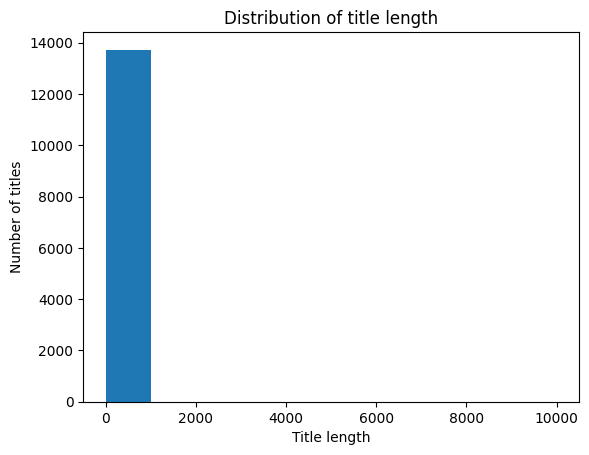

In [ ]:
#@ Histogram of all title length
plt.hist(rdt_train["title"].str.len(), bins=10, range=(0, 10000))
plt.title('Distribution of title length')
plt.xlabel('Title length')
plt.ylabel('Number of titles')
plt.show()

In [ ]:
#@title Distribution of labels in training and test sets
for i in range(np.max(train_labels)):
  pos_indices = np.where(train_labels == i)
  pct_positive = len(pos_indices[0])/len(train_labels)
  print(f'Labels {i} in training set: {len(pos_indices[0])}/{len(train_labels)} ({pct_positive})')

for i in range(np.max(val_labels)):
  pos_indices = np.where(val_labels == i)
  pct_positive = len(pos_indices[0])/len(val_labels)
  print(f'Labels {i} in validation set: {len(pos_indices[0])}/{len(val_labels)} ({pct_positive})')

for i in range(np.max(test_labels)):
  pos_indices = np.where(test_labels == i)
  pct_positive = len(pos_indices[0])/len(test_labels)
  print(f'Labels {i} in test set: {len(pos_indices[0])}/{len(test_labels)} ({pct_positive})')


Labels 0 in training set: 2465/13727 (0.17957310410140598)
Labels 1 in training set: 2422/13727 (0.17644059153493116)
Labels 2 in training set: 2407/13727 (0.17534785459313762)
Labels 3 in training set: 2450/13727 (0.17848036715961244)
Labels 4 in training set: 2001/13727 (0.14577110803525897)
Labels 0 in validation set: 248/1488 (0.16666666666666666)
Labels 1 in validation set: 248/1488 (0.16666666666666666)
Labels 2 in validation set: 248/1488 (0.16666666666666666)
Labels 3 in validation set: 248/1488 (0.16666666666666666)
Labels 4 in validation set: 248/1488 (0.16666666666666666)
Labels 0 in test set: 248/1488 (0.16666666666666666)
Labels 1 in test set: 248/1488 (0.16666666666666666)
Labels 2 in test set: 248/1488 (0.16666666666666666)
Labels 3 in test set: 248/1488 (0.16666666666666666)
Labels 4 in test set: 248/1488 (0.16666666666666666)


In [ ]:
mh_cls_names = list(rdt_train.class_name.unique())
mh_cls_names
mh_cls_id = list(rdt_train.class_id.unique())
mh_cls_id

mh_dict_id_to_name = {}
mh_dict_name_to_id = {}
for idx, value in enumerate(mh_cls_id):
    mh_dict_id_to_name[value] = mh_cls_names[idx]
for idx, value in enumerate(mh_cls_names):
    mh_dict_name_to_id[value] = mh_cls_id[idx]

print(mh_dict_id_to_name)
print(mh_dict_name_to_id)


{0: 'adhd', 1: 'anxiety', 2: 'bipolar', 3: 'depression', 5: 'none', 4: 'ptsd'}
{'adhd': 0, 'anxiety': 1, 'bipolar': 2, 'depression': 3, 'none': 5, 'ptsd': 4}


In [ ]:
mh_cls_id

[0, 1, 2, 3, 5, 4]

In [ ]:
mh_cls_names

['adhd', 'anxiety', 'bipolar', 'depression', 'none', 'ptsd']

In [ ]:
val_examples

array(["no links between ritalin and school shootings, as nra's oliver north claimed",
       '"but you\'re doing so much better!"', 'fucking finally!', ...,
       'drug seekers are the worst',
       'i had my first panic attack without my (now ex) boyfriend there to help me.',
       'got noticed at the grocery store'], dtype='<U180')

In [ ]:
#@title BERT Tokenization of training, validation and test data

def tokenize_train_val(tokenizer, train_examples, val_examples):

    train_examples_str = [x for x in train_examples]
    val_examples_str = [x for x in val_examples]

    # Tokenize training, validation and test data
    bert_train_tokenized = tokenize_data(tokenizer, train_examples_str)
    bert_val_tokenized = tokenize_data(tokenizer, val_examples_str)

    bert_train_inputs = [bert_train_tokenized.input_ids,
                        bert_train_tokenized.token_type_ids,
                        bert_train_tokenized.attention_mask]


    bert_val_inputs = [bert_val_tokenized.input_ids,
                        bert_val_tokenized.token_type_ids,
                        bert_val_tokenized.attention_mask]


    return bert_train_inputs, bert_val_inputs

In [ ]:
def tokenize_data(tokenizer, input_str):
  tokenized = tokenizer(input_str,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
  return tokenized

In [ ]:
#@title BERT Tokenization of training, validation and test data

def tokenize_test(tokenizer, test_examples):

    test_examples_str = [x for x in test_examples]

    # Tokenize training, validation and test data
    bert_test_tokenized = tokenize_data(tokenizer, test_examples_str)

    bert_test_inputs = [bert_test_tokenized.input_ids,
                        bert_test_tokenized.token_type_ids,
                        bert_test_tokenized.attention_mask]


    return bert_test_inputs

In [ ]:
#@title BERT Tokenization of training, validation and test data

def roberta_tokenize_train_val(tokenizer, train_examples, val_examples):

    train_examples_str = [x for x in train_examples]
    val_examples_str = [x for x in val_examples]

    # Tokenize training, validation and test data
    train_tokenized = tokenize_data(tokenizer, train_examples_str)
    val_tokenized = tokenize_data(tokenizer, val_examples_str)

    train_inputs = [train_tokenized.input_ids,
                        train_tokenized.attention_mask]


    val_inputs = [val_tokenized.input_ids,
                        val_tokenized.attention_mask]


    return train_inputs, val_inputs

In [ ]:
#@title Train RoBERTa model - use CLS token
def create_roberta_cls_model(base_model,
                          max_sequence_length=MAX_SEQUENCE_LENGTH,
                          hidden_size = 100,
                          dropout=0.3,
                          learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the CLS Token output for classification purposes.
    """

    base_model.trainable = True

    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

    inputs = {'input_ids': input_ids,
              'attention_mask': attention_mask}

    # change dummy input for bert; Some hack to make load model
    # https://wormtooth.com/20221229-save-bert-model-correctly/
    # It did not work though !!
    features = tf.constant([[0] * max_sequence_length])
    base_model._saved_model_inputs_spec = None
    base_model._set_save_spec(features)

    roberta_out = base_model(inputs)
    # roberta_out = base_model([input_ids, attention_mask])

    # The first token of every example is a CLS token
    cls_embedding = roberta_out[0][:, 0, :]
    print(cls_embedding.shape)

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_embedding)

    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    classification = tf.keras.layers.Dense(6, activation='softmax',name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                                 metrics='accuracy')

    return classification_model




In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

In [ ]:
def roberta_main(train, val, tlabels, vlabels, fraction):
    """
    Main function to train RoBerta model
    """

    # Load training, validation and test data
    tsamples = train[0:int(fraction*len(train))]
    vsamples = val[0:int(fraction*len(val))]

    train_samples = tsamples
    val_samples = vsamples

    # Tokenize training, validation and test data
    roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    roberta_train_inputs, roberta_val_inputs = roberta_tokenize_train_val(roberta_tokenizer, train_samples, val_samples)

    # Convert labels to numpy arrays
    roberta_train_labels = np.array(tlabels)
    roberta_train_sample_labels = roberta_train_labels[0:int(fraction*len(tlabels))]

    roberta_val_labels = np.array(vlabels)
    roberta_val_sample_labels = roberta_val_labels[0:int(fraction*len(vlabels))]

    # Create classification model
    config_l = RobertaConfig.from_pretrained("roberta-base")
    config_l.num_max_position_embeddingslabels =  ROBERTA_MAX_EMBEDDINGS

    roberta_model = TFRobertaModel.from_pretrained('roberta-base', config = config_l)
    roberta_classification_model = create_roberta_cls_model(roberta_model, hidden_size=HIDDEN_LAYER_SIZE)

    roberta_classification_model.summary()

    roberta_classification_model_history = roberta_classification_model.fit(
        roberta_train_inputs,
        roberta_train_sample_labels,
        validation_data=(roberta_val_inputs, roberta_val_sample_labels),
        batch_size=8, #8,
        epochs=5,
        callbacks=[early_stopping, model_checkpoint]
    )

    return roberta_classification_model, roberta_classification_model_history


In [ ]:
fraction = 1

In [ ]:
model, model_history = roberta_main(train_examples, val_examples, train_labels, val_labels, fraction)

(None, 768)
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 128)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 128)]                0         []                            
 r)                                                                                               
                                                                                                  
 tf_roberta_model_4 (TFRobe  TFBaseModelOutputWithPooli   1246456   ['attention_mask_layer[0][0]',
 rtaModel)                   ngAndCrossAttentions(last_   32         'input_ids_

1716/1716 [==============================] - 189s 87ms/step - loss: 1.2872 - accuracy: 0.4935 - val_loss: 1.0564 - val_accuracy: 0.6035
Epoch 2/5
1716/1716 [==============================] - 133s 78ms/step - loss: 0.9632 - accuracy: 0.6521 - val_loss: 0.9726 - val_accuracy: 0.6384
Epoch 3/5
1716/1716 [==============================] - 132s 77ms/step - loss: 0.8595 - accuracy: 0.6918 - val_loss: 0.9988 - val_accuracy: 0.6526
Epoch 4/5
1716/1716 [==============================] - 132s 77ms/step - loss: 0.7677 - accuracy: 0.7319 - val_loss: 0.9464 - val_accuracy: 0.6660
Epoch 5/5
1716/1716 [==============================] - 131s 77ms/step - loss: 0.6944 - accuracy: 0.7585 - val_loss: 1.0236 - val_accuracy: 0.6586


In [ ]:
# 256
#
#
# 1716/1716 [==============================] - 260s 129ms/step - loss: 1.2576 - accuracy: 0.5145 - val_loss: 1.0151 - val_accuracy: 0.6230
# Epoch 2/5
# 1716/1716 [==============================] - ETA: 0s - loss: 0.9280 - accuracy: 0.6655/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
#   saving_api.save_model(
# 1716/1716 [==============================] - 212s 124ms/step - loss: 0.9280 - accuracy: 0.6655 - val_loss: 0.8929 - val_accuracy: 0.6714
# Epoch 3/5
# 1716/1716 [==============================] - 212s 123ms/step - loss: 0.8150 - accuracy: 0.7078 - val_loss: 0.8822 - val_accuracy: 0.6801
# Epoch 4/5
# 1716/1716 [==============================] - 208s 121ms/step - loss: 0.7161 - accuracy: 0.7483 - val_loss: 1.0176 - val_accuracy: 0.6660
# Epoch 5/5
# 1716/1716 [==============================] - 208s 121ms/step - loss: 0.6156 - accuracy: 0.7868 - val_loss: 1.0290 - val_accuracy: 0.6895

In [ ]:
# Save the model
path = f'drive/MyDrive/MIDS/w266/02_final_project/mids-w266-project/saved_models/{input_model}_titles'
if not os.path.exists(path):
  os.makedirs(path, exist_ok=True)
print(f'Saving model to {path}')
tf.keras.models.save_model(model, path)

Saving model to drive/MyDrive/MIDS/w266/02_final_project/mids-w266-project/saved_models/roberta_titles


In [ ]:
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
test_examples_list = test_examples.tolist()
test_tokens = tokenize_data(roberta_tokenizer, test_examples_list)
y_prediction = model.predict((test_tokens['input_ids'], test_tokens['attention_mask']))

47/47 [==============================] - 6s 74ms/step


In [ ]:
y_pred_label = np.argmax(y_prediction, axis=1) # Convert probabilities to discrete class labels

	 Printing confusion matrix


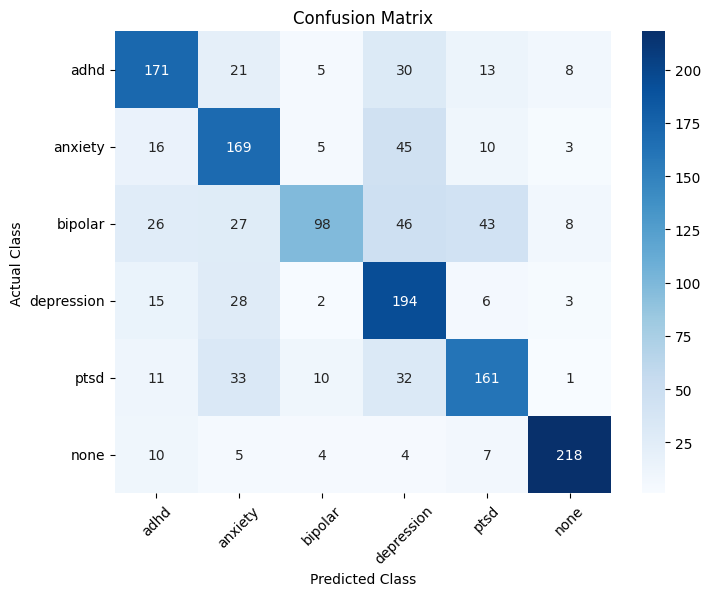

Accuracy: 0.6794354838709677
              precision    recall  f1-score   support

        adhd       0.69      0.69      0.69       248
     anxiety       0.60      0.68      0.64       248
     bipolar       0.79      0.40      0.53       248
  depression       0.55      0.78      0.65       248
        ptsd       0.67      0.65      0.66       248
        none       0.90      0.88      0.89       248

    accuracy                           0.68      1488
   macro avg       0.70      0.68      0.68      1488
weighted avg       0.70      0.68      0.68      1488



In [ ]:
from sklearn.metrics import confusion_matrix
print('\t Printing confusion matrix')
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(test_labels, y_pred_label)

# Plot the confusion matrix
actuals_names = [mh_dict_id_to_name[i] for i in range(len(mh_cls_names))]
predictions_names = [mh_dict_id_to_name[i] for i in range(len(mh_cls_names))]

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(result, annot=True, fmt='d', cmap='Blues')

# Add string labels to the axes
plt.xticks(ticks=np.arange(len(actuals_names)) + 0.5, labels=actuals_names, rotation=45)
plt.yticks(ticks=np.arange(len(predictions_names)) + 0.5, labels=predictions_names, rotation=0)

# Add labels, title, and color bar
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.title('Confusion Matrix')
plt.show()

print(f'Accuracy: {accuracy_score(test_labels, y_pred_label)}')

print(classification_report(test_labels, y_pred_label, target_names=predictions_names))

In [ ]:
fraction
# 0.7856182795698925

1

In [ ]:
print('\t Saving all mismatches')
# Plot the confusion matrix
actuals_names = [mh_dict_id_to_name[i] for i in range(len(mh_cls_names))]
predictions_names = [mh_dict_id_to_name[i] for i in range(len(mh_cls_names))]

mismatches = []
for i in range(len(test_labels)):
    if test_labels[i] != y_pred_label[i]:
        id1 = test_labels[i]
        id2 = y_pred_label[i]
        entry = {}
        entry['actual'] = actuals_names[id1]
        entry['predicted'] = predictions_names[id2]
        entry['test_id'] = i
        entry['text'] = test_examples[i]
        mismatches.append(entry)
df = pd.DataFrame(mismatches)
df.to_csv('drive/MyDrive/MIDS/w266/02_final_project/mids-w266-project/mismatches_roberta_titles.csv', index=False)


	 Saving all mismatches
